<a href="https://colab.research.google.com/github/psiudo/Statististical-Rethinking/blob/main/Chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. The Many Variables & The Spurious Waffles

In [1]:
import pandas as pd

# WaffleDivorce 데이터 다운로드
!wget https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv

# 데이터 로드
data = pd.read_csv("WaffleDivorce.csv", sep=';')

# 데이터 확인
print(data.head())
print(data.columns)


--2025-01-18 19:59:05--  https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3189 (3.1K) [text/plain]
Saving to: ‘WaffleDivorce.csv’

WaffleDivorce.csv   100%[===================>]   3.11K  --.-KB/s    in 0s      

2025-01-18 19:59:05 (51.0 MB/s) - ‘WaffleDivorce.csv’ saved [3189/3189]

     Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA      

In [2]:
from sklearn.preprocessing import StandardScaler

# Divorce와 MedianAgeMarriage 열 표준화
scaler = StandardScaler()
data["D"] = scaler.fit_transform(data[["Divorce"]])
data["A"] = scaler.fit_transform(data[["MedianAgeMarriage"]])

# 표준화된 데이터 확인
print(data[["D", "A"]].head())


          D         A
0  1.671000 -0.612445
1  1.560044 -0.693671
2  0.616916 -0.206314
3  2.114824 -1.424706
4 -0.936470  0.605947


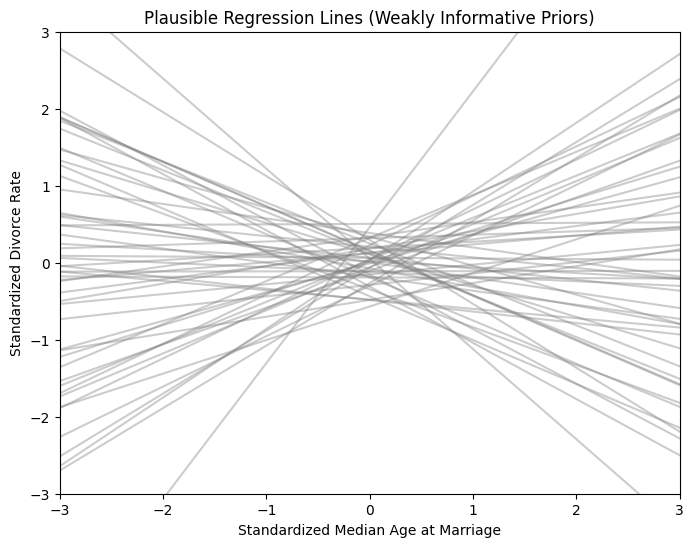

In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 약한 정보성 사전 분포를 사용한 모델 정의
with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=0.2)  # 절편
    bA = pm.Normal("bA", mu=0, sigma=0.5)  # 기울기
    sigma = pm.Exponential("sigma", lam=1)  # 오차

    # 선형 모델
    mu = a + bA * data["A"]  # A는 표준화된 MedianAgeMarriage 열
    D_obs = pm.Normal("D_obs", mu=mu, sigma=sigma, observed=data["D"])  # D는 표준화된 Divorce 열

    # 사전 분포 샘플링
    prior_samples = pm.sample_prior_predictive(samples=50, return_inferencedata=True)

# prior_predictive에서 a와 bA 추출
a_samples = prior_samples.prior["a"].values.flatten()  # a 샘플
bA_samples = prior_samples.prior["bA"].values.flatten()  # bA 샘플

# 회귀선 시각화
A_range = np.linspace(-3, 3, 100)  # A 범위 설정
plt.figure(figsize=(8, 6))
for i in range(len(a_samples)):
    plt.plot(
        A_range,
        a_samples[i] + bA_samples[i] * A_range,
        color="gray",
        alpha=0.4,
    )
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("Standardized Median Age at Marriage")
plt.ylabel("Standardized Divorce Rate")
plt.title("Plausible Regression Lines (Weakly Informative Priors)")
plt.show()


--2025-01-18 19:59:31--  https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3189 (3.1K) [text/plain]
Saving to: ‘WaffleDivorce.csv’

WaffleDivorce.csv   100%[===================>]   3.11K  --.-KB/s    in 0s      

2025-01-18 19:59:32 (55.1 MB/s) - ‘WaffleDivorce.csv’ saved [3189/3189]



Output()

Output()

<ipython-input-4-791eebc7b2d5>:36: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_PI = az.hdi(mu_samples.reshape(-1, 30), hdi_prob=0.89)  # 신뢰 구간 계산 (크기: (30, 2))


A_seq shape: (30,)
mu_samples shape: (2, 1000, 30)
mu_mean shape: (30,)
mu_PI shape: (30, 2)


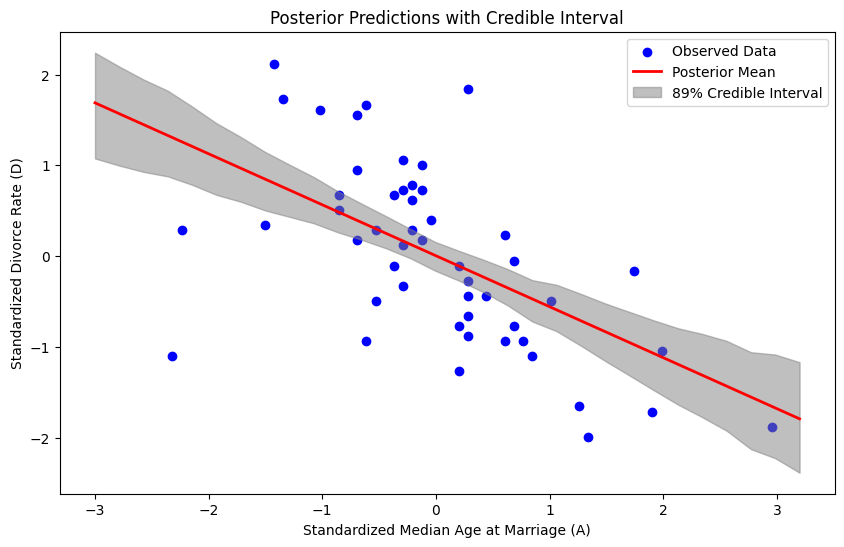

In [4]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 표준화
!wget -O WaffleDivorce.csv https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv
data = pd.read_csv("WaffleDivorce.csv", sep=";")
scaler = StandardScaler()
data["D"] = scaler.fit_transform(data[["Divorce"]])  # Divorce 표준화
data["A"] = scaler.fit_transform(data[["MedianAgeMarriage"]])  # MedianAgeMarriage 표준화

# A_seq 설정
A_seq = np.linspace(-3, 3.2, 30)

# PyMC 모델 정의
with pm.Model() as model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=0.2)  # 절편
    bA = pm.Normal("bA", mu=0, sigma=0.5)  # 기울기
    sigma = pm.Exponential("sigma", lam=1)  # 오차

    # 선형 모델
    mu = pm.Deterministic("mu", a + bA * A_seq)  # A_seq와 연산
    D_obs = pm.Normal("D_obs", mu=a + bA * data["A"], sigma=sigma, observed=data["D"])  # 관측 데이터

    # 샘플링
    trace = pm.sample(1000, return_inferencedata=True, cores=2)
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["mu"], extend_inferencedata=True)

# 사후 분포 요약
mu_samples = posterior_predictive.posterior_predictive["mu"].values  # (2, 1000, 30)
mu_mean = mu_samples.mean(axis=(0, 1))  # 모든 샘플에 대해 평균 계산 (크기: (30,))
mu_PI = az.hdi(mu_samples.reshape(-1, 30), hdi_prob=0.89)  # 신뢰 구간 계산 (크기: (30, 2))

# 크기 확인
print("A_seq shape:", A_seq.shape)
print("mu_samples shape:", mu_samples.shape)
print("mu_mean shape:", mu_mean.shape)
print("mu_PI shape:", mu_PI.shape)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data["A"], data["D"], color="blue", label="Observed Data")  # 관측 데이터
plt.plot(A_seq, mu_mean, color="red", lw=2, label="Posterior Mean")  # 평균 회귀선
plt.fill_between(A_seq, mu_PI[:, 0], mu_PI[:, 1], color="gray", alpha=0.5, label="89% Credible Interval")  # 신뢰 구간
plt.xlabel("Standardized Median Age at Marriage (A)")
plt.ylabel("Standardized Divorce Rate (D)")
plt.title("Posterior Predictions with Credible Interval")
plt.legend()
plt.show()


In [5]:
pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00


## 5.1.1. Think before you regress

*   Divorce rate(D)
*   Marrage rate(M)
*   Median agea at mariage(A)



In [ ]:
from pgmpy.models import BayesianNetwork

# 첫 번째 DAG 정의
dag1 = BayesianNetwork([("A", "M"), ("M", "D"), ("A", "D")])

# 두 번째 DAG 정의
dag2 = BayesianNetwork([("A", "M"), ("A", "D")])

print("DAG1 Structure:")
print(dag1.edges())

print("\nDAG2 Structure:")
print(dag2.edges())


DAG1 Structure:
[('A', 'M'), ('A', 'D'), ('M', 'D')]

DAG2 Structure:
[('A', 'M'), ('A', 'D')]
